# Bookworm


## Overview

Build a simple question-answering agent that is able to learn from any text data you provide, and answer queries posed in natural language. Use IBM Watson's cloud-based services to process the input text data and find relevant responses.

## Objectives

- Create a cloud-based NLP service instance and configure it.
- Ingest a set of text documents using the service and analyze the results.
- Accept questions in natural language and parse them.
- Find relevant answers from the preprocessed text data.

## Getting Started

In order to use Watson's cloud-based services, you first need to create an account on the [IBM Bluemix platform](https://console.ng.bluemix.net/).

<div>
    <div style="display: table-cell; width: 50%;">
        <img src="images/watson-logo.png" alt="IBM Watson logo" width="200" />
    </div>
    <div style="display: table-cell; width: 50%;">
        <img src="images/bluemix-logo.png" alt="IBM Bluemix logo" width="400" />
    </div>
</div>

Then, for each service you want to use, you have to create an instance of that service. You can continue with the tasks below, and create a service instance when indicated.

## 1. Create and configure Discovery service

Create an instance of the **Discovery** service. You will use this to process a set of text documents, and _discover_ relevant facts and relationships.

- Go to the [IBM Bluemix Catalog](https://console.ng.bluemix.net/catalog/?taxonomyNavigation=services&category=watson).
- Select the service you want, **Discovery**, under the **Watson** category.
- Enter a Service Name for that instance, e.g. **Disco1** and a Credential Name, e.g. **Disco1-Creds** (these are just for you to be able to refer to later, they do not affect the functioning of the service).
- You should be able to see your newly-created service in your [Services Dashboard](https://console.ng.bluemix.net/dashboard/services).
- Open the service instance, click on the **Service credentials** tab, and then **View credentials** under Actions. This is where you will find the username and password to use when connecting to the service.

<img src="images/discovery-creds.png" alt="Discovery Service - Credentials tab" width="800" />

Save the credentials for the discovery service in a JSON file in the current directory named `service-credentials.json` with the following format:

```json
{
    "discovery": {
        "username": "<your Discovery username here>",
        "password": "<your Discovery password here>"
    },
    "conversation": {
        "username": "",
        "password": ""
    }
}

```

You will be filling out the Conversation service credentials later, when you create an instance for it. Note that you should keep these credentials secret. 

### Connect to the service instance

Let's connect to the service instance you just created using IBM Watson's [Python SDK](https://github.com/watson-developer-cloud/python-sdk). You will first need to install the SDK:
```bash
pip install watson-developer-cloud
```

Now execute each code cell below using **`Shift+Enter`**, and complete any steps indicated by a **`TODO`** comment. For more information on the Discovery service, please read the [Documentation](https://www.ibm.com/watson/developercloud/doc/discovery/index.html) and look at the [API Reference](https://www.ibm.com/watson/developercloud/discovery/api/v1/?python) as needed.

In [1]:
# Usual Python imports
import sys
import os
import glob
import json

# BeautifulSoup, for parsing HTML
from bs4 import BeautifulSoup

# Matplotlib, for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Watson Python SDK
import watson_developer_cloud

# Utility functions
import helper

In [2]:
# Connect to the Discovery service instance
# Ensure that your username and password from the Service Credentials tab are in service-credentials.json
# Note that these credentials are different from your IBM Bluemix login, and are specific to the service instance
discovery_creds = helper.fetch_credentials('discovery')
discovery = watson_developer_cloud.DiscoveryV1(
    version='2016-11-07',
    username=discovery_creds['username'],
    password=discovery_creds['password'])

### Create an environment

The Discovery service organizes everything needed for a particular application in an _environment_. Let's create one called "Bookworm" for this project.

> _**Note**: It is okay to run this block multiple times - it will not create duplicate environments with the same name._

In [3]:
# Prepare an environment to work in
env, env_id = helper.fetch_object(
    discovery, "environment", "Bookworm",
    create=True, create_args=dict(
        description="A space to read and understand stories",  # feel free to edit
        size=0  # use 0 for FREE plan (see API reference for more on sizing)
    ))
print("Watson Discovery Service App Environment: ", json.dumps(env, indent=2))

Found environment: Bookworm (b670995b-b998-4335-b3e0-ec77bcc3e56e)
Watson Discovery Service App Environment:  {
  "environment_id": "b670995b-b998-4335-b3e0-ec77bcc3e56e",
  "name": "Bookworm",
  "description": "A space to read and understand stories",
  "created": "2017-07-01T02:18:39.808Z",
  "updated": "2017-07-01T02:18:39.808Z",
  "status": "active",
  "read_only": false,
  "size": 0,
  "index_capacity": {
    "disk_usage": {
      "used_bytes": 0,
      "total_bytes": 4294967296,
      "used": "0 KB",
      "total": "4 GB",
      "percent_used": 0.0
    },
    "memory_usage": {
      "used_bytes": 113933704,
      "total_bytes": 1056309248,
      "used": "108.66 MB",
      "total": "1007.38 MB",
      "percent_used": 10.79
    }
  }
}


### Verify configuration options

A _configuration_ defines what NLP routines are applied to any documents that submitted to the service. Each environment gets a default configuration when created.

Fetch default configuration and view different options using the following code.


In [4]:
# View default configuration
cfg_id = discovery.get_default_configuration_id(environment_id=env_id)
cfg = discovery.get_configuration(environment_id=env_id, configuration_id=cfg_id)
print(json.dumps(cfg, indent=2))

{
  "configuration_id": "1af6fdb1-bdf7-4b7b-83e0-7bdf2a6ba417",
  "name": "Default Configuration",
  "description": "The configuration used by default when creating a new collection without specifying a configuration_id.",
  "created": "2017-07-01T02:18:39.838Z",
  "updated": "2017-07-01T02:18:39.838Z",
  "conversions": {
    "word": {
      "heading": {
        "fonts": [
          {
            "level": 1,
            "min_size": 24,
            "bold": false,
            "italic": false
          },
          {
            "level": 2,
            "min_size": 18,
            "max_size": 23,
            "bold": true,
            "italic": false
          },
          {
            "level": 3,
            "min_size": 14,
            "max_size": 17,
            "bold": false,
            "italic": false
          },
          {
            "level": 4,
            "min_size": 13,
            "max_size": 13,
            "bold": true,
            "italic": false
          }
        ],
    

There are 3 main configuration blocks that affect how input documents are processed:
 
1. **`conversions`**: How to convert documents in various formats (Word, PDF, HTML) and extract elements that indicate some structure (e.g. headings).
2. **`enrichments`**: What NLP output results are we interested in (keywords, entities, sentiment, etc.).
3. **`normalizations`**: Post-processing steps to be applied to the output. This can be left empty in most cases, unless you need the output to be normalized into a very specific format.

_**Note**: The default configuration for an environment cannot be modified. If you need to change any of the options, you will need to create a new one, and then edit it. The easiest way to do this is using the service dashboard, which is described later._

### Test your configuration

It is a good idea to test your configuration on a small sample text before you apply it to a larger document collection.

_**Note**: Supplied a sample document (`data/sample.html`) containing the opening crawl text for Star Wars: Episode IV, but you are free to use a text of your choosing._


In [5]:
# Test configuration on some sample text
data_dir = "data"
filename = os.path.join(data_dir, "sample.html")
res = {}
with open(filename, "r") as f:
    res = discovery.test_document(environment_id=env_id, configuration_id=cfg_id, fileinfo=f)
print(json.dumps(res, indent=2))

{
  "status": "completed",
  "enriched_field_units": 1,
  "original_media_type": "text/html",
  "snapshots": [
    {
      "step": "html_input",
      "snapshot": {
        "html": "<html>\n<head>\n    <title>Star Wars: Episode IV - A New Hope (Opening Crawl)</title>\n</head>\n<body>\n    <article>\n        <h1>Star Wars: Episode IV - A New Hope (Opening Crawl)</h1>\n        <p>\n            It is a period of civil war. Rebel spaceships, striking from a hidden base, have won their first victory against the evil Galactic Empire.\n        </p><p>\n            During the battle, Rebel spies managed to steal secret plans to the Empire's ultimate weapon, the DEATH STAR, an armored space station with enough power to destroy an entire planet.\n        </p><p>\n            Pursued by the Empire's sinister agents, Princess Leia races home aboard her starship, custodian of the stolen plans that can save her people and restore freedom to the galaxy...\n        </p>\n    </article>\n</body>"
     

### Analyze test output

The results returned by the service contain a _snapshot_ of the information extracted at each step of processing - document conversions, enrichments and normalizations. We are interested in the output of applying enrichments (`"enrichments_output"`) or after normalizing them (`"normalizations_output"`). These should be identical if no post-processing/normalizations were specified in the configuration.

In [6]:
# Take a closer look at the results from the "enrichments_output" or "normalizations_output" step
output = next((s["snapshot"] for s in res["snapshots"] if s["step"] == "enrichments_output"), None)
print("Enrichments Output: ", json.dumps(output, indent=2))

Enrichments Output:  {
  "extracted_metadata": {
    "title": "Star Wars: Episode IV - A New Hope (Opening Crawl)"
  },
  "html": "<?xml version='1.0' encoding='UTF-8' standalone='yes'?><html>\n<head>\n    <meta content=\"text/html; charset=UTF-8\" http-equiv=\"Content-Type\"/>\n    \n    <title>Star Wars: Episode IV - A New Hope (Opening Crawl)</title>\n\n\n</head>\n<body>\n\n\n    <article>\n        <h1>Star Wars: Episode IV - A New Hope (Opening Crawl)</h1>\n        <p>\n            It is a period of civil war. Rebel spaceships, striking from a hidden base, have won their first victory against the evil Galactic Empire.\n        </p><p>\n            During the battle, Rebel spies managed to steal secret plans to the Empire's ultimate weapon, the DEATH STAR, an armored space station with enough power to destroy an entire planet.\n        </p><p>\n            Pursued by the Empire's sinister agents, Princess Leia races home aboard her starship, custodian of the stolen plans that can sa

Answer the following questions based on the output above. Note that it contains the input HTML, extracted text and metadata as well as the actual enrichment results (`"enriched_text"` block).

#### Sentiment

**Q**: What is the overall sentiment detected in this text? Mention the `type` (positive/negative) and `score`.<br />
(_Hint: Look for the `"docSentiment"` key in the output._)

**A**: 
* The `enriched_text` gives the `docSentiment` property that provides the overall sentiment detected in the text as being:
  * Type `negative`
  * Score `-0.575489`


#### Concepts

**Q**: List 3 concepts that have been identified with a relevance > 0.5. Note that not all concepts here may be present directly in the text, some may have been inferred by Watson.<br />
(_Hint: Look for `"concepts"`._)

**A**:

* The `enriched_text` gives the `concepts` property that provides concepts with different levels of relevance:
  * `text` "Star Wars" with `relevance` 0.985705
  * `text` "Rebel Alliance" with `relevance` 0.90639
  * `text` "Luke Skywalker" with `relevance` 0.805771


#### Relations

Each relation is essentially a deeper analysis of a sentence (or part of a sentence). Here is a sample relation:
```json
{
  "sentence": " During the battle, Rebel spies managed to steal secret plans to the Empire's ultimate weapon, the DEATH STAR, an armored space station with enough power to destroy an entire planet.",
  "subject": {
    "text": "Rebel spies",
    "keywords": [
      {
        "text": "Rebel spies"
      }
    ]
  },
  "action": {
    "text": "managed to steal",
    "lemmatized": "manage to steal",
    "verb": {
      "text": "steal",
      "tense": "future"
    }
  },
  "object": {
    "text": "secret plans",
    "keywords": [
      {
        "text": "secret plans"
      }
    ]
  }
 }
```

In this case, Watson seems to have done a pretty good job of extracting some meaning from the sentence.

**Q**: Find a relation where the extracted meaning is not as accurate, or not what you would've expected. List the `sentence`, `subject`, `action` and `object` parts as identified, and what you would've marked instead.<br />
(_Hint: Look for `"relations"`._)

**A**: 

* The `relations` property gives a list of different relation properties, of which the following one is not what I would have expected
    * `"sentence": " Pursued by the Empire's sinister agents, Princess Leia races home aboard her starship, custodian of the stolen plans that can save her people and restore freedom to the galaxy...",`
    * `"subject": {
          "text": "by the Empire",
          "sentiment": {
            "type": "positive",
            "score": 0.554106,
            "mixed": false
          },
          "keywords": [
            {
              "text": "Empire"
            }
          ]
        },
        "object": {
          "text": "Princess Leia",
          "sentiment": {
            "type": "positive",
            "score": 0.682563,
            "mixed": false
          },
          "keywords": [
            {
              "text": "Princess Leia"
            }
          ]
        }
      },`
    * I would NOT have marked the for the `object` fact that Princess Leia is racing home with stolen plan whilst being chased by the Empire's sinister agents as being a `positive` Sentiment. Instead I would have marked it as being of Type `neutral` sentiment with Score `0`. I would NOT have marked just the text of a persons' title and plain name (i.e. "Princess Leia") as being of any sentiment at all (i.e. if the her title was instead say "Princess of Love" then I would have marked it as being of "positive" sentiment, or if it were "Princess of Evil" then I would have marked it as being of `negative` sentiment). 
    * I would NOT have given the `subject` text of "by the Empire" such as high Score as `0.554106`. I agree that the combination of words "by the" implies that something is being done, but I don't think it should have a Score that high. Instead I would have considered the the context of the `subject` in more detail (i.e. "Pursued by the Empire's sinister agents"), and given that context I would have kept the current Score, by changed the Sentiment Type to `negative`.


#### Keywords

You may have noticed that Watson identifies some `"keywords"` in the relations, e.g. `"Rebel spies"` and `"secret plans"` in the Star Wars example above. The output also contains a list of all keywords at the top level, for your convenience, along with their relevance to the document and sentiment conveyed. Let's visualize these keywords as a word cloud!

Note: We'll be using this handy [worldcoud library](https://github.com/amueller/word_cloud) to generate the visualization. So you will need to install it first:
```bash
pip install wordcloud
```

(-0.5, 4999.5, 2190.5, -0.5)

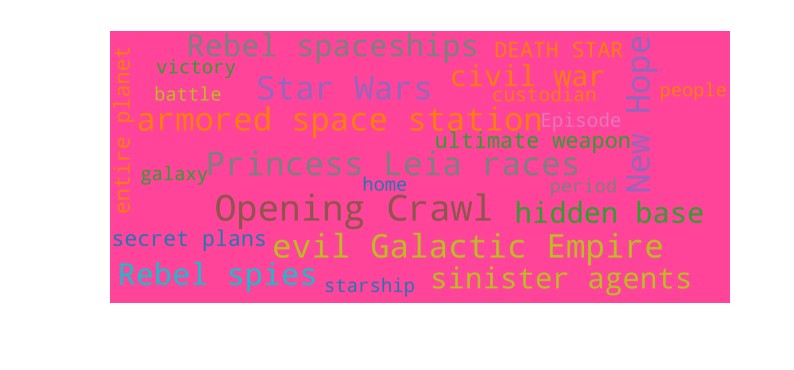

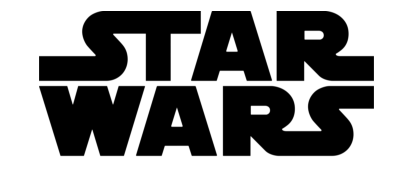

In [7]:
# Visualize keywords by relevance as a wordcloud
from wordcloud import WordCloud
from os import path
from PIL import Image
import numpy as np

d = path.dirname(os.getcwd() + '/AIND-NLP-Bookworm')
star_wars_logo_mask = np.array(Image.open(path.join(d, "star_wars.png")))

wc_data = { w["text"]: w["relevance"] for w in output["enriched_text"]["keywords"] }
wc = WordCloud(width=400, 
               height=300, 
               scale=2, 
               background_color="#ff4499",
               colormap="tab10",
               mask=star_wars_logo_mask)
wc.generate_from_frequencies(wc_data)  # use precomputed relevance instead of frequencies

plt.figure(figsize=(4, 3), dpi=200)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.imshow(star_wars_logo_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")

Feel free to play with this visualization and improve it. What about using a different metric instead of relevance, e.g. direct word frequencies that the wordcloud library computes by default?

#### Other results

Watson's output also includes processed results from other enrichments that were applied to the text, including entities and taxonomy (what topic or category does this text relate to).

```json
"taxonomy": [
  {
    "label": "/art and entertainment/movies and tv/movies",
    "score": 0.584247,
    "confident": false
  },
  {
    "label": "/society/unrest and war",
    "score": 0.517031,
    "confident": false
  },
  {
    "confident": false,
    "label": "/law, govt and politics/armed forces/army",
    "score": 0.215561
  }
],
```

Get a good sense of all the different pieces of information available in the results. Start thinking about which ones will be useful for looking up answers to questions, and how you might use them.

## 2. Ingest documents

### Create a collection

A _collection_ is used to organize documents of the same kind. For instance, you may want to create a collection of book reviews, or a collection of Wikipedia articles, but it may not make much sense to mix the two groups. This allows Watson to make meaningful inferences over the set of documents, find commonalities and identify important concepts.

Let's create one called "Story Chunks".

In [8]:
# Prepare a collection of documents to use
col, col_id = helper.fetch_object(discovery, 
                                  "collection", 
                                  "Story Chunks", 
                                  environment_id=env_id,
                                  create=True, 
                                  create_args=dict(
                                    environment_id=env_id, 
                                    configuration_id=cfg_id,
                                    description="Stories and plots split up into chunks suitable for answering"
                                    )
                                 )
print(json.dumps(col, indent=2))

Created collection: Story Chunks (ce1896f7-b0d2-445c-9d5d-9d957a13443d)
{
  "name": "Story Chunks",
  "collection_id": "ce1896f7-b0d2-445c-9d5d-9d957a13443d",
  "description": "Stories and plots split up into chunks suitable for answering",
  "created": "2017-07-01T04:05:26.274Z",
  "updated": "2017-07-01T04:05:26.274Z",
  "configuration_id": "1af6fdb1-bdf7-4b7b-83e0-7bdf2a6ba417",
  "language": "en",
  "status": "active"
}


Once you have created a collection, you should be able to view it using the Discovery Service tool. To open, go to the **Manage** tab for your service instance, and click the **Launch tool** button.

<img src="images/discovery-manage.png" alt="Discovery service - Manage tab" width="800" />


Here you should see the "Story Chunks" collection you just created.

<img src="images/discovery-tooling.png" alt="Discovery service - Tool showing collections" width="800" />

You can open the collection to view more details about it. If you need to modify configuration options, click the **Switch** link and create a new configuration (the default one cannot be changed).

### Add documents

Okay, now that we have everything set up, let's add a set of "documents" we want Watson to look up answers from, using the Python SDK. Note that Watson treats each "document" as a unit of text that is returned as the result of a query. But we want to retrieve a paragraph of text for each question. So, let's split each file up into individual paragraphs. We will use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library for this purpose.

_**Note**: You could also add and manage documents in the collection using the Discovery tool, but you would have to split paragraphs up into separate files._

_**Note**: Provided a set of files (`data/Star-Wars/*.html`) with summary plots for Star Wars movies, but you are free to use a collection of your choice. Open one of the files in a text editor to see how the paragraphs are delimited using `<p>...</p>` tags - this is how the code block below split paragraphs into separate "documents"._

In [9]:
# Add documents to collection
doc_ids = []  # to store the generated id for each document added
for filename in glob.glob(os.path.join(data_dir, "Star-Wars", "*.html")):
    print("Adding file:", filename)
    with open(filename, "r") as f:
        # Split each individual <p> into its own "document"
        doc = f.read()
        soup = BeautifulSoup(doc, 'html.parser')
        for i, p in enumerate(soup.find_all('p')):
            doc_info = discovery.add_document(environment_id=env_id, collection_id=col_id,
                file_data=json.dumps({"text": p.get_text(strip=True)}),
                mime_type="application/json",
                metadata={"title": soup.title.get_text(strip=True)})
            doc_ids.append(doc_info["document_id"])
print("Total", len(doc_ids), "documents added.")

Adding file: data/Star-Wars/Episode-I_The-Phantom-Menace.html
Adding file: data/Star-Wars/Episode-II_Attack-of-the-Clones.html
Adding file: data/Star-Wars/Episode-III_Revenge-of-the-Sith.html
Adding file: data/Star-Wars/Episode-IV_A-New-Hope.html
Adding file: data/Star-Wars/Episode-V_The-Empire-Strikes-Back.html
Adding file: data/Star-Wars/Episode-VI_Return-of-the-Jedi.html
Adding file: data/Star-Wars/Episode-VII_The-Force-Awakens.html
Adding file: data/Star-Wars/Rogue-One.html
Total 42 documents added.


If you look at the collection details, you may notice that the `"document_counts"` field now shows some documents as `available` or `processing`. Once processing is complete, you should see all the documents under the `available` count.

In [11]:
# View collection details to verify all documents have been processed
col, col_id = helper.fetch_object(discovery, "collection", "Story Chunks", environment_id=env_id)
print("Collection data: ", json.dumps(col, indent=2))

Found collection: Story Chunks (ce1896f7-b0d2-445c-9d5d-9d957a13443d)
Collection data:  {
  "collection_id": "ce1896f7-b0d2-445c-9d5d-9d957a13443d",
  "name": "Story Chunks",
  "configuration_id": "1af6fdb1-bdf7-4b7b-83e0-7bdf2a6ba417",
  "language": "en",
  "status": "active",
  "description": "Stories and plots split up into chunks suitable for answering",
  "created": "2017-07-01T04:05:26.274Z",
  "updated": "2017-07-01T04:05:26.274Z",
  "document_counts": {
    "available": 42,
    "processing": 0,
    "failed": 0
  },
  "training_status": {
    "data_updated": "",
    "total_examples": 0,
    "sufficient_label_diversity": false,
    "processing": false,
    "minimum_examples_added": false,
    "successfully_trained": "",
    "available": false,
    "notices": 0,
    "minimum_queries_added": false
  }
}


So, what did the Discovery service learn? If you list the fields extracted from the set of documents in the collection as part of the enrichment process, you'll see familiar fields like `concepts`, `entities` and `keywords` that were returned in the test analysis.

In [12]:
# List all fields extracted
discovery.list_collection_fields(environment_id=env_id, collection_id=col_id)

{'fields': [{'field': 'ce1896f7-b0d2-445c-9d5d-9d957a13443d.mappings.document._all.analyzer',
   'type': 'english'},
  {'field': 'enriched_text', 'type': 'nested'},
  {'field': 'extracted_metadata', 'type': 'nested'},
  {'field': 'metadata', 'type': 'nested'},
  {'field': 'text', 'type': 'string'},
  {'field': 'text.analyzer', 'type': 'english'},
  {'field': 'enriched_text.properties.concepts', 'type': 'nested'},
  {'field': 'enriched_text.properties.docSentiment', 'type': 'nested'},
  {'field': 'enriched_text.properties.entities', 'type': 'nested'},
  {'field': 'enriched_text.properties.keywords', 'type': 'nested'},
  {'field': 'enriched_text.properties.language', 'type': 'string'},
  {'field': 'enriched_text.properties.language.analyzer', 'type': 'english'},
  {'field': 'enriched_text.properties.relations', 'type': 'nested'},
  {'field': 'enriched_text.properties.status', 'type': 'string'},
  {'field': 'enriched_text.properties.status.analyzer', 'type': 'english'},
  {'field': 'enric

### Test query

Let's perform a simple query to see if the service can fetch the proper document for us:
> _Look for all paragraphs that have a relation (sentence) with "Jar Jar" as the subject, and return the title and text._


In [13]:
# A simple query
results = discovery.query(environment_id=env_id, collection_id=col_id,
    query_options={
        "query": "enriched_text.relations.subject.text:\"Jar Jar\"",
        "return": "metadata.title,text"
    })
print(json.dumps(results, indent=2))

{
  "matching_results": 2,
  "results": [
    {
      "id": "c62b14fb-12ae-4504-8a3f-2a554e318368",
      "score": 2.9906685,
      "metadata": {
        "title": "Star Wars: Episode I - The Phantom Menace"
      },
      "text": "Supreme Chancellor Valorum, leader of the Galactic Republic, dispatches Jedi Knight Qui-Gon Jinn and his apprentice, Obi-Wan Kenobi, to negotiate with the Trade Federation leadership to end a blockade of battleships around the planet Naboo. Darth Sidious, a Sith Lord and the Trade Federation's secret adviser, orders Federation Viceroy Nute Gunray to kill the Jedi and invade Naboo with an army of battle droids. The Jedi escape and flee to Naboo, where Qui-Gon saves a Gungan outcast, Jar Jar Binks, from being run over and killed by a droid tank during the invasion. Indebted to the Jedi, Jar Jar leads them to an underwater Gungan city. The Jedi unsuccessfully try to persuade the Gungan leader, Boss Nass, into helping the people of Naboo, though they are able to 

In [45]:
# A simple query
# Note: `filter` runs first and is faster than `query` and is cached, then `query`, 
# `aggregation`, and `natural_language_query` follow running in parallel
#
# Links:
#   https://www.ibm.com/watson/developercloud/doc/discovery/query-reference.html
#   https://www.ibm.com/watson/developercloud/doc/discovery/using.html
#   https://www.ibm.com/watson/developercloud/doc/discovery/query-reference.html#aggregations
results = discovery.query(environment_id=env_id, collection_id=col_id,
    query_options={
        "query": "enriched_text.relations.subject.text::\"Luke Skywalker\", \
                  enriched_text.keywords.text:meteor|wampa, \
                  enriched_text.keywords.text::!\"Rebel Alliance\"",
        "return": "metadata.title,text"
    })
print(json.dumps(results, indent=2))

{
  "matching_results": 1,
  "results": [
    {
      "id": "cfe75e89-59dd-45d0-b7a8-ae84caeb0bfa",
      "score": 5.573014,
      "metadata": {
        "title": "Star Wars: Episode V - The Empire Strikes Back"
      },
      "text": "While investigating a potential meteor strike, Luke Skywalker is injured and captured by a wampa, a yeti-like creature. He manages to escape from its cave with his lightsaber, but soon succumbs to the brutally cold temperatures and collapses. The ghost of his late mentor, Obi-Wan Kenobi, instructs him to go to the Dagobah system to train under Jedi Master Yoda. He is found by Han Solo, who kills his tauntaun and uses its warmth to keep Luke warm while he sets up a shelter. Han and Luke make it through the night and are rescued by a search party."
    }
  ]
}


## 3. Parse natural language questions

In order to understand questions posed in natural language, we'll use another Watson service called [Conversation](https://www.ibm.com/watson/developercloud/doc/conversation/index.html). It can be used to design conversational agents or _chatbots_ that exhibit complex behavior, but for the purpose of this project, we'll only use it to parse certain kinds of queries.

### Create a Conversation service instance

Just like you did for the Discovery service, create an instance of the Conversation service. Then launch the associated tool from the service dashboard.

<img src="images/conversation-tooling.png" alt="Conversation service - Tool homepage" width="800" />

A _workspace_ allows you to keep all the items you need for a particular application in one place, just like an _environment_ in case of the Discovery service. Create one called "Bookworm" with a suitable description, such as "I know a lot of stories. Ask me a question!"

<img src="images/conversation-workspace.png" alt="Conversation service - Blank workspace" width="800" />

This should open up a blank workspace, where you can add intents, define the entities you want the agent to idenitfy and structure the overall dialog.

### Add intents

An _intent_ is the goal or purpose of a user's input. Create a set of intents (at least 3) that capture the different kinds of questions that you want the system to answer, e.g. _who_, _what_ and _where_. Along with each intent, add a list of user examples or _utterances_ that map to that intent.

For instance, you could enter the following examples for the _where_ intent:

- Where is the Jedi temple located?
- Where was Luke born?

The Conversation service recommends at least 5 examples for each intent so that Watson learns how to recognize it. These don't have to be very precise, but more examples the better.

<img src="images/conversation-intents.png" alt="Conversation service - Intents listed" width="800" />

Feel free to create your own intents, based on the kinds of questions you want the system to answer, e.g. "How many ...", "What are the most common ..." etc. Each intent will need to be mapped to an appropriate query.

> See [**Defining intents**](https://www.ibm.com/watson/developercloud/doc/conversation/intents.html) for a helpful video and further instructions.


### Add entities

Once you have your intents set, let's tell the service what entities we want it to identify. One way to do this is using the tool interface, and entering them one-by-one.

> Go to [**Defining entities**](https://www.ibm.com/watson/developercloud/doc/conversation/entities.html) to see how that is done.

But that can be tedious! So let's refer back to the entities that the Discovery service identified, and load them in programmatically.

As before, let's connect to the Conversation service first. Remember to enter your service credentials below.

In [46]:
# Connect to the Conversation service instance
# Enter your username and password from the Service Credentials tab in service-credentials.json
conversation_creds = helper.fetch_credentials('conversation')
conversation = watson_developer_cloud.ConversationV1(
    version='2017-02-03',
    username=conversation_creds['username'],
    password=conversation_creds['password'])

Fetch the workspace you just created called "Bookworm".

In [47]:
wrk, wrk_id = helper.fetch_object(conversation, "workspace", "Bookworm")
print(json.dumps(wrk, indent=2))

Found workspace: Bookworm (8bef8691-bf77-41f1-9bb0-1c58d41f0263)
{
  "name": "Bookworm",
  "created": "2017-07-01T05:49:13.672Z",
  "updated": "2017-07-01T06:15:22.393Z",
  "language": "en",
  "metadata": null,
  "description": "I know a lot of stories. Ask me a question!",
  "workspace_id": "8bef8691-bf77-41f1-9bb0-1c58d41f0263",
  "status": "Available"
}


Collect all the entities from the Discovery service collection.

In [48]:
# Get all the entities from the collection and group them by type
response = discovery.query(environment_id=env_id, collection_id=col_id,
    query_options={
        "return": "enriched_text.entities.type,enriched_text.entities.text"
    })

# Group individual entities by type ("Person", "Location", etc.)
entities_by_type = {}
for document in response["results"]:
    for entity in document["enriched_text"]["entities"]:
        if entity["type"] not in entities_by_type:
            entities_by_type[entity["type"]] = set()
        entities_by_type[entity["type"]].add(entity["text"])

# Ignore case to avoid duplicates
for entity_type in entities_by_type:
    entities_by_type[entity_type] = {
        e.lower(): e for e in entities_by_type[entity_type]
    }.values()

# Restructure for loading into Conversation workspace
entities_grouped = [{
    "entity": entity_type,
    "values": [{"value": entity} for entity in entities]}
        for entity_type, entities in entities_by_type.items()]
entities_grouped


[{'entity': 'Person',
  'values': [{'value': 'Darth Vader'},
   {'value': 'Senator Padmé Amidala'},
   {'value': 'Organa'},
   {'value': 'Viceroy Nute Gunray'},
   {'value': 'Anakin'},
   {'value': 'Supreme Chancellor Palpatine'},
   {'value': 'Beru Lars'},
   {'value': 'Boss Nass'},
   {'value': 'Queen Amidala'},
   {'value': 'Gunray'},
   {'value': 'Obi-Wan'},
   {'value': 'Luke'},
   {'value': 'Polis Massa'},
   {'value': 'Count Dooku'},
   {'value': 'Jango Fett'},
   {'value': 'Darth Sidious'},
   {'value': 'Zam Wesell'},
   {'value': 'Watto'},
   {'value': 'Padmé'},
   {'value': 'Qui-Gon'},
   {'value': 'Mace Windu'},
   {'value': 'Palpatine'},
   {'value': 'Geonosis'},
   {'value': 'Chancellor Valorum'},
   {'value': 'Vader'},
   {'value': 'Boba'},
   {'value': 'Shmi'},
   {'value': 'Princess Leia'},
   {'value': 'Senator Palpatine'},
   {'value': 'Cliegg Lars'},
   {'value': 'Owen'},
   {'value': 'Leia'},
   {'value': 'Amidala'},
   {'value': 'Mustafar'},
   {'value': 'Anakin Sk

Update the workspace with these entities and verify that have been added correctly.

In [147]:
# Add these grouped entities to the Conversation workspace
conversation.update_workspace(workspace_id=wrk_id, entities=entities_grouped)

workspace_details = conversation.get_workspace(workspace_id=wrk_id, export=True)
print(json.dumps(workspace_details["entities"], indent=2))

[
  {
    "type": null,
    "entity": "Country",
    "source": null,
    "values": [
      {
        "value": "Naboo",
        "created": "2017-07-01T09:38:56.832Z",
        "updated": "2017-07-01T09:38:56.832Z",
        "metadata": null,
        "synonyms": []
      }
    ],
    "created": "2017-07-01T09:38:56.832Z",
    "updated": "2017-07-01T09:38:56.832Z",
    "open_list": null,
    "description": null
  },
  {
    "type": null,
    "entity": "City",
    "source": null,
    "values": [
      {
        "value": "Gungans",
        "created": "2017-07-01T09:38:56.832Z",
        "updated": "2017-07-01T09:38:56.832Z",
        "metadata": null,
        "synonyms": []
      },
      {
        "value": "Theed",
        "created": "2017-07-01T09:38:56.832Z",
        "updated": "2017-07-01T09:38:56.832Z",
        "metadata": null,
        "synonyms": []
      },
      {
        "value": "Podrace",
        "created": "2017-07-01T09:38:56.832Z",
        "updated": "2017-07-01T09:38:56.832Z",
 

Personal Notes:

- Intents/Utterances represent Verbs (user desired action)
	- Each represent same intent (i.e. #what, #where, #who)
- Entities represent Nouns (context/object for an action)
	- https://www.ibm.com/watson/developercloud/doc/conversation/entities.html
	- Create Entity when want to change way app responds to an Intent
	- i.e. Entity is what user wants specific to the Intent (i.e. #what)
	such as:
		- @teams, which has Possible Values such as rebel alliance, resistance, republic, stormtrooper, falcon
		- @location with Possible Values such as bespin
	- Note: Each Possible Value may be accompanied by associated Synonyms
	treated as the same value as multiple ways user may refer to it 
	(i.e. for "falcon" maybe include "Millennium Falcon", etc)

_**Note**: Ensure that at least 3 entity types, with at least 1 example entity each have been added._

Here is what the list of entities should look like through the Conversation tool.

<img src="images/conversation-entities.png" alt="Conversation service - Entities listed" width="800" />



### Design dialog flow

As a final step in creating the Conversation interface, let's design a typical dialog with a user. The most intuitive way to do this is to use the Dialog tab in the tool. Here, you can add _nodes_ that capture different stages in the dialog flow, and connect them in a meaningful way.

Go ahead and add at least 3 dialog nodes. Specify the triggers in terms of the intents and entities that you'd like to match, and an optional intermediate response like "Let me find that out for you." The actual response will be fetched by querying the Discovery service.

Here is what the dialog nodes should look like.

<img src="images/conversation-dialog_nodes.png" alt="Conversation service - Dialog nodes" width="640" />



### Test dialog

Let's run through a test dialog to demonstrate how the system transitions to one of the nodes you defined above.

In [50]:
# Testing the dialog flow

# Start conversation with a blank message
results = conversation.message(workspace_id=wrk_id, message_input={})
context = results["context"]

# Then ask a sample question
question= "Who is Luke's father?"
results = conversation.message(workspace_id=wrk_id, message_input={
    "text": question,
    "context": context
})
print(json.dumps(results, indent=2))

{
  "intents": [
    {
      "intent": "who",
      "confidence": 0.6586461067199707
    }
  ],
  "entities": [
    {
      "entity": "Person",
      "location": [
        7,
        11
      ],
      "value": "Luke",
      "confidence": 1
    },
    {
      "entity": "Person",
      "location": [
        7,
        11
      ],
      "value": "Luke Skywalker",
      "confidence": 1
    }
  ],
  "input": {
    "text": "Who is Luke's father?",
    "context": {
      "conversation_id": "79688775-2418-4fdd-818d-b1568f82f5f3",
      "system": {
        "dialog_stack": [
          {
            "dialog_node": "root"
          }
        ],
        "dialog_turn_counter": 1,
        "dialog_request_counter": 1,
        "_node_output_map": {
          "Welcome": [
            0
          ]
        },
        "branch_exited": true,
        "branch_exited_reason": "completed"
      }
    }
  },
  "output": {
    "text": [
      "\"Let me find out who for you!\""
    ],
    "nodes_visited": [
     

## 4. Query document collection to fetch answers

The Discovery service includes a simple mechanism to make queries against your enriched collection of documents. But you have a lot of control over what fields are searched, how results are aggregated and values are returned.

### Process sample question

Choose a sample natural language question to ask, and run it through the Conversation service, just like you did above when testing dialog flow.

In [79]:
# Then ask a sample question
question= "Where is Luke from?"
results = conversation.message(workspace_id=wrk_id, message_input={
    "text": question,
    "context": context
})
print(json.dumps(results, indent=2))


{
  "intents": [
    {
      "intent": "where",
      "confidence": 0.8507129549980164
    }
  ],
  "entities": [
    {
      "entity": "Person",
      "location": [
        9,
        13
      ],
      "value": "Luke",
      "confidence": 1
    },
    {
      "entity": "Person",
      "location": [
        9,
        13
      ],
      "value": "Luke Skywalker",
      "confidence": 1
    }
  ],
  "input": {
    "text": "Where is Luke from?",
    "context": {
      "conversation_id": "79688775-2418-4fdd-818d-b1568f82f5f3",
      "system": {
        "dialog_stack": [
          {
            "dialog_node": "root"
          }
        ],
        "dialog_turn_counter": 1,
        "dialog_request_counter": 1,
        "_node_output_map": {
          "Welcome": [
            0
          ]
        },
        "branch_exited": true,
        "branch_exited_reason": "completed"
      }
    }
  },
  "output": {
    "text": [
      "\"Let me get the place for you!\""
    ],
    "nodes_visited": [
    

Now extract the intent and entities identified in the question, and optionally what dialog node was triggered (in case you need it later to customize your response). Some sample code is provided below, but you may need to modify it.

In [81]:
# Identify the intent(s) the user expressed (typically a single one)
query_intents = [intent["intent"] for intent in results["intents"]]
print("Intent(s):", query_intents)

# Extract the entities found in the question text
query_entities = [entity["value"] for entity in results["entities"]]
print("Entities's value:", query_entities)

# Find out what dialog node was triggered
query_dialog_nodes = [dialog_list["dialog_node"] for dialog_list in results["context"]["system"]["dialog_stack"]]
print("Dialog Node(s):", query_dialog_nodes)

Intent(s): ['where']
Entities's value: ['Luke', 'Luke Skywalker']
Dialog Node(s): ['root']


### Query the collection

Design a query based on the information extracted above, and run it against the document collection. The sample query provided below simple looks for all the entities in the raw `text` field. Modify it to suit your needs.

Take a look at the [API Reference](https://www.ibm.com/watson/developercloud/discovery/api/v1/?python#query-collection) to learn more about the query options available, and for more guidance see this [documentation page](https://www.ibm.com/watson/developercloud/doc/discovery/using.html).

_**Note**: You may want to design different queries based on the intent / dialog node that was triggered._

In [145]:
# Query the Discovery service based on the intent and entities
query_entities_params = ",".join("{}".format(e) for e in query_entities)

query_results = discovery.query(environment_id=env_id, collection_id=col_id,
    query_options={
        "filter": "enriched_text.docSentiment.type:positive, \
                   enriched_text.entities::(relevance>0.7), \
                   enriched_text.relations.subject.text:\'{}\'".format(query_entities_params,query_entities_params),
                  
        "query": "text:{}".format(query_entities_params),
        "aggregations": "term(enriched_text.concepts.text,count:2)",
        "passages": True,
        "return": "metadata.title,text"
    })
print(json.dumps(query_results, indent=2))

{
  "matching_results": 1,
  "passages": [
    {
      "document_id": "4f2ccd6c-900a-4817-97a9-57807216a32a",
      "passage_score": 5.404027820970151,
      "passage_text": "Obi-Wan views Leia's complete message, in which she begs him to take the Death Star plans to her home planet of Alderaan and give them to her father for analysis. Obi-Wan invites Luke to accompany"
    },
    {
      "document_id": "4f2ccd6c-900a-4817-97a9-57807216a32a",
      "passage_score": 5.404027820970151,
      "passage_text": " him to Alderaan and learn the ways of the Force. Luke declines, but changes his mind after discovering that Imperial stormtroopers searching for C-3PO and R2-D2 have destroyed his home and killed his"
    },
    {
      "document_id": "4f2ccd6c-900a-4817-97a9-57807216a32a",
      "passage_score": 5.404027820970151,
      "passage_text": " aunt and uncle. Obi-Wan and Luke hire smuggler Han Solo and his Wookiee first mate Chewbacca to transport them to Alderaan on Han's ship, the Mill

### Process returned results

If you properly structure the query, Watson is able to do a pretty good job of finding the relevant information. But the result returned is a JSON object. Now your task is to convert that result into an appropriate response that best addresses the original natural language question that was asked.

E.g. if the question was "Who saved Han Solo from Jabba the Hutt?" the answer should ideally just be "The Rebels" and not the entire paragraph describing Han Solo's rescue. But that can be a backup response if you cannot be more specific.

_**Note**: You may have to go back to the previous step and modify the query, especially what you want the Discovery service to return, and this may depend on the intent / dialog node triggered. E.g. study the different parts of a "relation" structure to see how you might construct queries to match them._

In [165]:
def get_best_response(entities, query_results):
    # fetch list of entity locations
    entity_locations = []
    for entity in entities:
        if entity["entity"] in ["City","Country"]:
            for value in enumerate(entity["values"]):
                entity_locations.append(value[1]["value"])
    print("Entity locations: ", entity_locations)

    location_counts = {}
    # aggregate entity location counts using a dictionary
    # for the 'results' property
    for i, location in enumerate(entity_locations):
        for j, result in enumerate(query_results["results"]):
            location_counts[location] = result["text"].count(location)

    # continue aggregating entity location counts using a dictionary
    # for each of the 'passage' properties
    for i, location in enumerate(entity_locations):
        for j, passage in enumerate(query_results["passages"]):
            location_counts[location] += passage["passage_text"].count(location)
    print("Total location counts: ", location_counts)
    
    # return the key that has the largest value (count) in the dict
    return max(location_counts, key=location_counts.get)

best_response = get_best_response(workspace_details["entities"], query_results)

print("Best response: ", best_response)
        

Entity locations:  ['Naboo', 'Gungans', 'Theed', 'Podrace', 'Coruscant', 'Alderaan', 'Kashyyyk', 'Mustafar', 'Gungan', 'Padmé', 'Valorum', 'Tusken', 'Geonosis']
Total location counts:  {'Naboo': 0, 'Gungans': 0, 'Theed': 0, 'Podrace': 0, 'Coruscant': 0, 'Alderaan': 6, 'Kashyyyk': 0, 'Mustafar': 0, 'Gungan': 0, 'Padmé': 0, 'Valorum': 0, 'Tusken': 0, 'Geonosis': 0}
Best response:  Alderaan
